# Predicting Closing Price

In [1]:
import yfinance as yf

In [35]:
# Download historical data from yahoo finance
df = yf.download("PFE", start="2008-04-05", end="2019-04-05")

df.dropna() # drop NaN

# Calculating the simple moving average for different windows
SMAs = [7, 14, 21]
for i in SMAs:
    # we use the fourth column that corresponds to the Closing Price
    df["SMA "+str(i)]= df["Close"].rolling(window=i).mean()

# Calculate the 7 day standard deviation
df["STD 7"]= df["Close"].rolling(window=i).std()
    
# look at the data
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA 7,SMA 14,SMA 21,STD 7
Date,,,,,,,,,,
2019-03-29,40.227703,40.398483,40.028461,40.294117,37.247612,21681834,40.023041,39.867173,39.904220,0.567620
2019-04-01,40.398483,40.740040,40.370018,40.645161,37.572113,20345046,40.089455,39.942396,39.880726,0.522387
2019-04-02,40.749527,40.967743,40.550285,40.711575,37.633511,18625129,40.233125,40.003388,39.873498,0.508988
2019-04-03,40.787476,40.863377,40.370018,40.645161,37.572113,16200402,40.361886,40.115207,39.871239,0.505262
2019-04-04,40.597721,40.721062,40.322582,40.550285,37.484406,12990972,40.405259,40.180265,39.910997,0.524853


In [36]:
# Create new variables
df["H-L"] = df.iloc[:,1] - df.iloc[:,2]
df["O-C"] = df.iloc[:,0] - df.iloc[:,3]

# This is the feature set
X = df.iloc[:,6:]

# This is the prediction set
Y = df["Close"]

Divide into training and test data set

In [37]:
Xtrain = X.loc["2009-04-06":"2017-04-03",:]; 
Ytrain = Y.loc["2009-04-07":"2017-04-04"] # Should be 1 day ahead

Xtest = X.loc["2017-04-04":"2019-04-03",:]; 
Ytest = Y.loc["2017-04-05":"2019-04-04"]

In [38]:
# Look at the training data
Xtrain.head()

,SMA 7,SMA 14,SMA 21,STD 7,H-L,O-C
Date,,,,,,
2009-04-06,13.063161,13.183790,13.102919,0.468690,0.616698,-0.142315
2009-04-07,12.991326,13.133641,13.142676,0.399192,0.237192,0.104364
2009-04-08,12.961507,13.118731,13.160296,0.372974,0.332068,0.056926
2009-04-09,12.952020,13.113310,13.194633,0.299863,0.351045,0.066414
2009-04-13,12.882895,13.076715,13.170236,0.311338,0.284631,0.047438


In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(Xtrain, Ytrain)

RandomForestRegressor()

In [40]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Ytest, rf.predict(Xtest))*100 # Evaluation score

6.226911971795357

In [41]:
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(hidden_layer_sizes=(3), 
                   max_iter=int(2e4),
                   activation = 'relu', # default=’relu’
                   solver='lbfgs', # default=’adam’
                   alpha = 0.0001, # default=0.0001
                   max_fun = 35000, # default=15000
                   learning_rate='adaptive', # default=’constant’
                   learning_rate_init = 0.001, # default=0.001
                   shuffle = True, 
                   tol = 1e-4 # default=1e-4
                  ) 
ann.fit(Xtrain,Ytrain);

MAPE = mean_absolute_percentage_error(Ytrain, ann.predict(Xtrain))*100
print("Training MAPE = %f%%" % MAPE)

Training MAPE = 1.295818%


In [42]:
# Evaluation score
MAPE = mean_absolute_percentage_error(Ytest, ann.predict(Xtest))*100
print("Test MAPE = %f%%" % MAPE)

Test MAPE = 1.087439%


Create dataframe with dates so that it is easier to plot

In [43]:
import pandas as pd

dates = list(Ytest.index.values) # get dates
Yguess = pd.DataFrame(ann.predict(Xtest), columns=['Close'], index = dates)

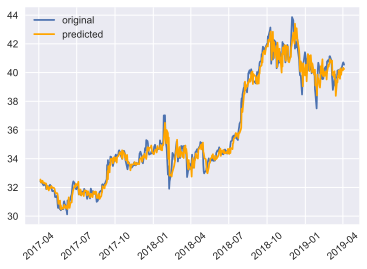

In [44]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')
%matplotlib inline

plt.xticks(rotation=40)
plt.plot(Ytest)
plt.plot(Yguess,'orange')

plt.legend(['original','predicted'])

# Predict if closing price is positive or negative

In [62]:
import numpy as np

# Calculate the difference in closing price between dates
df["Diff Close"] = df["Close"].diff()
df["Sign"] = np.where(df['Diff Close'] > 0, 1, -1)

# This is the prediction set
Y = df["Sign"]

Divide into training and test data set

In [63]:
Xtrain = X.loc["2009-04-06":"2017-04-03",:]; 
Ytrain = Y.loc["2009-04-07":"2017-04-04"] # Should be 1 day ahead

Xtest = X.loc["2017-04-04":"2019-04-03",:]; 
Ytest = Y.loc["2017-04-05":"2019-04-04"]

In [100]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

ann = MLPClassifier(hidden_layer_sizes=(3), 
                   max_iter=int(2e4),
                   activation = 'relu', # default=’relu’
                   solver='lbfgs', # default=’adam’
                   alpha = 0.0001, # default=0.0001
                   max_fun = 1000, # default=15000
                   learning_rate='adaptive', # default=’constant’
                   learning_rate_init = 0.01, # default=0.001
                   shuffle = False,
                   tol = 1e-3 # default=1e-4
                  ) 
ann.fit(Xtrain,Ytrain)

Yguess = ann.predict(Xtest)
accuracy_score(Ytest, Yguess)

0.4850894632206759